In [1]:
import torch

print("CUDA available:", torch.cuda.is_available())
print("GPU count:", torch.cuda.device_count())
print("Current device:", torch.cuda.current_device())
print("GPU name:", torch.cuda.get_device_name(torch.cuda.current_device()) if torch.cuda.is_available() else "No GPU found")

CUDA available: True
GPU count: 1
Current device: 0
GPU name: NVIDIA GeForce RTX 3050 Laptop GPU


**Loading Dataset**

In [25]:
import os
import pandas as pd

# Go from: Code/Urgency Detection → Code → Project Root
PROJECT_ROOT = os.path.dirname(os.path.dirname(os.getcwd()))

DATA_PATH = os.path.join(
    PROJECT_ROOT,
    "Cleaned data",
    "final_email_dataset_clipped.csv"
)

df = pd.read_csv(DATA_PATH)

print(df.shape)
print(df.columns)


(502505, 5)
Index(['clean_text', 'category', 'auto_category', 'auto_urgency',
       'email_length'],
      dtype='object')


In [26]:
df.head()

,clean_text,category,auto_category,auto_urgency,email_length
0,Traveling to have a business meeting takes the...,unknown,other,low,783
1,test successful. way to go!!!,unknown,other,low,30
2,"Randy,\n Can you send me a schedule of the sal...",unknown,request,medium,185
3,Let's shoot for Tuesday at 11:45.,unknown,other,low,33
4,"Greg,\n How about either next Tuesday or Thurs...",unknown,other,low,57


**Making of Baseline Models**

In [28]:
from sklearn.model_selection import train_test_split

X = df['clean_text']
y = df['auto_urgency']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Training set size:", X_train.shape[0])
print("Test set size:", X_test.shape[0])

Training set size: 402004
Test set size: 100501


In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer( 
    max_features=5000,
    ngram_range=(1,2),
    stop_words='english'
)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)
print("TF-IDF training data shape:", X_train_tfidf.shape)
print("TF-IDF test data shape:", X_test_tfidf.shape)

TF-IDF training data shape: (402004, 5000)
TF-IDF test data shape: (100501, 5000)


In [32]:
import joblib
joblib.dump(vectorizer, "tfidf_vectorizer_urgency.pkl")
print("TF-IDF vectorizer saved as tfidf_vectorizer_urgency.pkl")

TF-IDF vectorizer saved as tfidf_vectorizer_urgency.pkl


In [33]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=1000, class_weight='balanced')
lr.fit(X_train_tfidf, y_train)
print("Logistic Regression model trained.")

Logistic Regression model trained.


In [34]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)
print("Naive Bayes model trained.")

Naive Bayes model trained.


In [35]:
from sklearn.metrics import classification_report

y_pred_lr = lr.predict(X_test_tfidf)
y_pred_nb = nb.predict(X_test_tfidf)

print("Logistic Regression Report")
print(classification_report(y_test, y_pred_lr))

print("Naive Bayes Report")
print(classification_report(y_test, y_pred_nb))


Logistic Regression Report
              precision    recall  f1-score   support

        high       0.92      0.96      0.94     10592
         low       0.82      0.88      0.85     41620
      medium       0.89      0.83      0.86     48289

    accuracy                           0.86    100501
   macro avg       0.88      0.89      0.88    100501
weighted avg       0.87      0.86      0.86    100501

Naive Bayes Report
              precision    recall  f1-score   support

        high       0.66      0.43      0.52     10592
         low       0.77      0.54      0.64     41620
      medium       0.64      0.85      0.73     48289

    accuracy                           0.68    100501
   macro avg       0.69      0.60      0.63    100501
weighted avg       0.69      0.68      0.67    100501



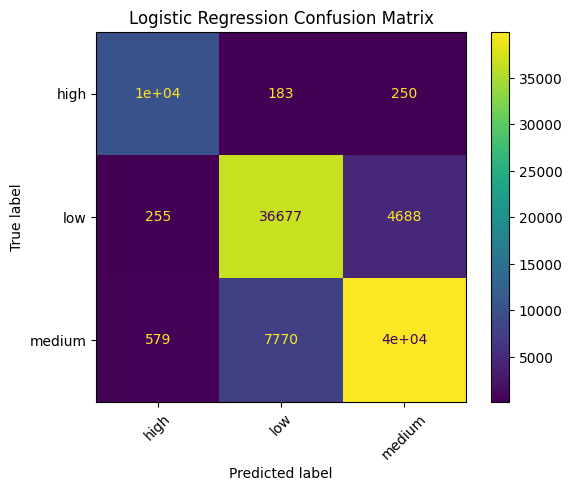

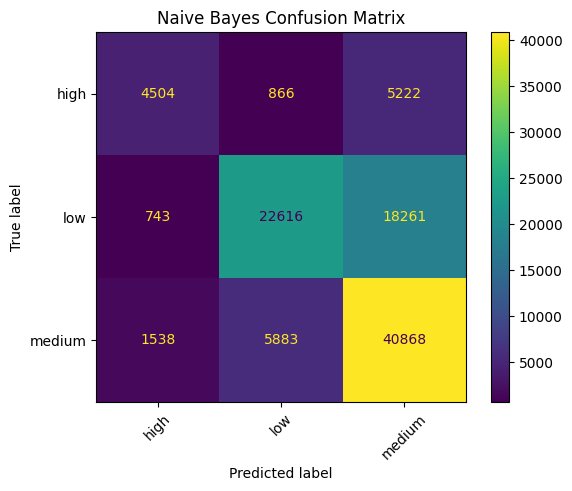

In [36]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ConfusionMatrixDisplay.from_estimator(lr, X_test_tfidf, y_test, xticks_rotation=45)
plt.title("Logistic Regression Confusion Matrix")
plt.show()
ConfusionMatrixDisplay.from_estimator(nb, X_test_tfidf, y_test, xticks_rotation=45)
plt.title("Naive Bayes Confusion Matrix")
plt.show()

In [37]:
import joblib

joblib.dump(lr, "urgency_logistic_regression_email_classifier.pkl")

print("✅ Model saved correctly")

✅ Model saved correctly
